In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from dateutil.relativedelta import relativedelta

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()


# reflect the tables
Base.prepare(autoload_with=engine)

['measurement', 'station']

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23',)

In [84]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date_string = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
most_recent_date_date = dt.datetime.strptime(most_recent_date_string,'%Y-%m-%d').date()

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date_date - relativedelta(years=1)

# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(measurement.date,func.sum(measurement.prcp).label("prcp")).\
    filter(measurement.date <= most_recent_date_date).\
    filter(measurement.date >= one_year_ago).\
    group_by(measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip_data)

# Sort the dataframe by date
precip_df.sort_values(by=['date'], ascending=False)


,date,prcp
365,2017-08-23,0.53
364,2017-08-22,0.50
363,2017-08-21,0.58
362,2017-08-20,0.01
361,2017-08-19,0.09
...,...,...
4,2016-08-27,0.32
3,2016-08-26,0.10
2,2016-08-25,0.54
1,2016-08-24,9.33


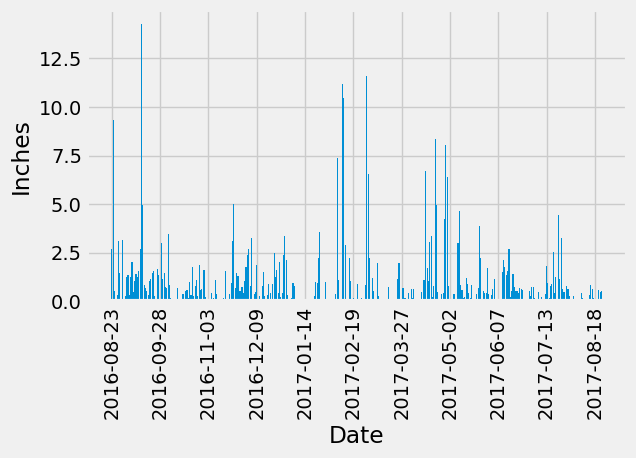

In [74]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots()
ax.bar(precip_df['date'], precip_df['prcp'])
ax.set_xticks(ax.get_xticks()[::36],rotation=90)
ax.set_xlabel('Date')
ax.set_ylabel('Inches')
plt.xticks(rotation=90)
fig.tight_layout()


In [75]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,366.000000
mean,0.978907
std,1.776349
min,0.000000
25%,0.052500
50%,0.405000
75%,1.087500
max,14.280000


# Exploratory Station Analysis

In [42]:
# Design a query to calculate the total number stations in the dataset
session.query(func.count(measurement.station)).all()

[(19550,)]

In [45]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(measurement.station,func.count(measurement.station)).group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [83]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = session.query(measurement.station,func.count(measurement.station)).group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()[0][0]

active_station_query = session.query(measurement.id, measurement.station, measurement.date, measurement.prcp, measurement.tobs).\
    filter(measurement.station == most_active_station).all()

active_station_df = pd.DataFrame(active_station_query)


#lowest
print(f"Min temp = {active_station_df['tobs'].describe()['min']}")

#highest
print(f"Max temp = {active_station_df['tobs'].describe()['max']}")

#mean
print(f"Mean temp = {active_station_df['tobs'].describe()['mean']}")



Min temp = 54.0
Max temp = 85.0
Mean temp = 71.66378066378067


In [53]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# date stuff
mrd_active = session.query(measurement.date).filter(measurement.station == most_active_station).order_by(measurement.date.desc()).first()[0]
mrd_active_date = dt.datetime.strptime(mrd_active,'%Y-%m-%d').date()
mrd_one_year_ago = mrd_active_date - relativedelta(years=1)

# make df
most_active_oneyear_data = session.query(measurement.id,measurement.station,measurement.date,measurement.prcp,measurement.tobs).\
    filter(measurement.station == most_active_station).\
    filter(measurement.date <= mrd_active_date).\
    filter(measurement.date >= mrd_one_year_ago).all()

most_active_oneyear_df = pd.DataFrame(most_active_oneyear_data)


Text(0, 0.5, 'Frequency')

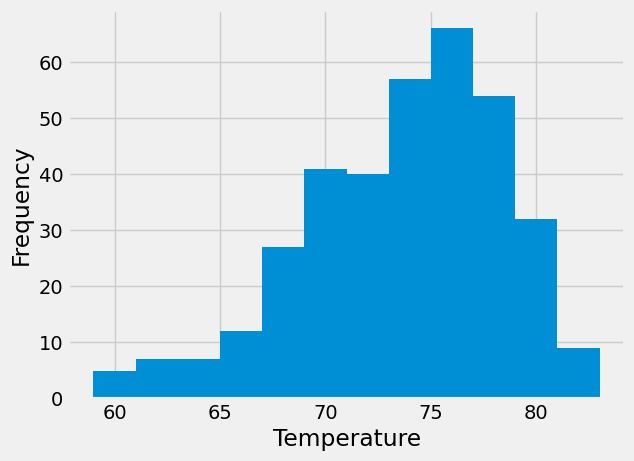

In [88]:
fig_2, ax_2 = plt.subplots()
ax_2.hist(most_active_oneyear_df['tobs'], bins=12)
ax_2.set_xlabel('Temperature')
ax_2.set_ylabel('Frequency')

# Close session

In [ ]:
# Close Session
session.close()